In [4]:
!pip install awswrangler

  Obtaining dependency information for awswrangler from https://files.pythonhosted.org/packages/eb/7f/3f0296b736de88a8b5c918e41053c69948a200939106a4e1fd64c5925c6a/awswrangler-3.3.0-py3-none-any.whl.metadata
  Using cached awswrangler-3.3.0-py3-none-any.whl.metadata (23 kB)
  Obtaining dependency information for typing-extensions<5.0.0,>=4.4.0 from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.16-py2.py3-none-any.whl.metadata (48 kB)
Using cached awswrangler-3.3.0-py3-none-any.whl (394 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
Using cached

In [5]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sqlalchemy import create_engine
import os
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')

In [4]:
query = """

select 
date_trunc('month', ult_disparo_email) as mes_envio_email --ultimo mes
, date_trunc('month',  ult_disparo_push) as mes_envio_push
, date_trunc('month',  ult_disparo_sms) as mes_envio_sms
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2,3


"""

In [5]:
# Clean temporary folder
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


In [7]:
df.head()

mes_envio_email mes_envio_push mes_envio_sms  clientes
0      2023-08-01     2023-06-01    2023-07-01     10403
1      2023-07-01     2023-07-01          None    178726
2      2023-03-01     2023-02-01    2023-03-01     10347
3      2023-07-01     2023-01-01    2023-03-01       299
4      2023-04-01     2023-08-01    2023-04-01       407

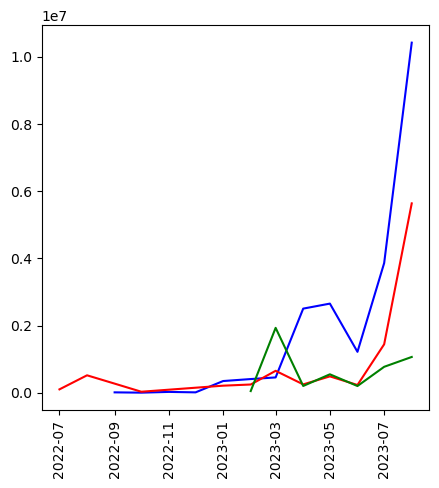

In [49]:
plt.figure(figsize = (5,5))
plt.plot(df.groupby('mes_envio_email').agg({'clientes':['sum']}), color = 'blue')
plt.plot(df.groupby('mes_envio_push').agg({'clientes':['sum']}), color = 'red')
plt.plot(df.groupby('mes_envio_sms').agg({'clientes':['sum']}), color = 'green')
plt.xticks(rotation=90)
plt.show()

In [50]:

query = """

select 
interacao_email
, interacao_push
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2


"""


wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df2 = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


<AxesSubplot:xlabel='clientes', ylabel='interacao_email'>

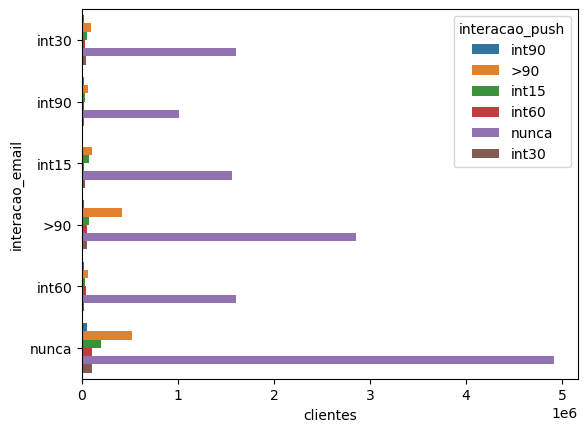

In [69]:
sns.barplot(data = df2, y = 'interacao_email', x = 'clientes', hue = 'interacao_push')

In [65]:
df2.sort_values(by = 'clientes', ascending = False).head(10)

interacao_email interacao_push  clientes
14           nunca          nunca   4919542
17             >90          nunca   2856178
33           int60          nunca   1602711
7            int30          nunca   1599580
26           int15          nunca   1566894
34           int90          nunca   1007963
18           nunca            >90    524602
9              >90            >90    421435
27           nunca          int15    195789
20           int15            >90    102343

In [7]:
query = """

select 
cpf
, max(case when interacao_email <> 'nunca' then 1 else 0 end) as flag_email
, max(case when interacao_push <> 'nunca' then 1 else 0 end) as flag_push
from martech_curated_zone.historico_acionamento_pmm_cliente
where (ult_disparo_email is not null or ult_disparo_push is not null)
and (interacao_email <> 'nunca' or interacao_push <> 'nunca')
group by 1
order by rand()
limit 50000


"""


wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df3 = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


In [8]:
len(df3)

50000

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 20, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(df3[['flag_email', 'flag_push']])
y_hc

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df3[['flag_email', 'flag_push']], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()